# Disability at six months (results)

In this notebook, we explore disability at 6 months and the change in disability between discharge and six months. It only analyses data from patients with disability recorded for both of those time points.

## Context about measurement of disability

Disability is measured using the modified Rankin Scale (mRS). The scale ranges from 0 to 6, where 0 is perfect health without symptoms and 6 is death. The dataset contains information on:
* Disability before the stroke
* Disability at discharge
* Disability at six months

It is an ordinal scale, which means that the categories have an order but there is not a consistent space between each score on the scale. This is one reason why some other analyses are focussing on utility, and we know the difference in utility for mRS 0 to mRS 3 is the difference between mRS 4 and 5, which indicates that a change from 4 to 5 reflects a greater change in health related quality of life than 0 to 1, and potentially a greater functional change. As mRS is ordinal, in SAMueL-2, we have generally chosen to only treat it as a **categorical** variable and not as a continuous variable.

## Aims

* Investigate disability at six months and change from discharge
* Investigate the factors associated with disability and change

## Purpose of this analysis

In other analyses, we are using discharge disability. One reason for that is because six month disability is so incomplete.

However, understanding the relationship between discharge disability and six month disability is useful context, if you were to start thinking about more long-term outcomes. There should be alot of sceptism around this analysis, however, for the reasons below.

## Caveats

Caveats of this data and analysis include...

**Follow-up is not missing at random.** Lots of patients are missing data on disability at six months, and this information is not missing at random. We know that the likelihood of having a follow-up assessment may be influenced by several different factors. We know that disability (including death) at six months is input manually (and so, case ascertainment is not more reliable for those died, but will vary between providers, as with the input of all mRS scores at 6 months). There are some SSNAP reports on their website where they link to mortality data from ONS once per year to report on mortality, but we do not have access to that.

**Variation in follow up date.** SSNAP data is provided for patients with a "follow-up assessment at six months post admission (plus or minus two months). This means that the data can actually be from 4 to 8 months after admission, which is a large amount of variability. It is possible that this variation may not be random (and that certain patients are more or less likely to be followed up earlier or later).

**Variation in discharge date.** SSNAP data on disability after stroke is provided for the point of discharge, but different patients will have different lengths of stay (likely influenced by patient/clinical characteristics). This means we are comparing disability that could be at very different lengths of time after the stroke.

**Confounders:** Change in disability could be due to factors besides stroke - such as other conditions not captured here.

## Summary

* **Distribution of disabiltiy:** At 6-months, there is a higher proportion of individuals with lower disability, and lower proportion of those with higher disability - with the exception of death.
* **Distribution of change in disability:** We most frequently see no change in disability (31.5%), then a change of one mRS score (apx. 40%), then two mRS (apx. 18%), three mRS (apx. 6%), and then very few with a change of four mRS or more
* **Factors associated with six month disability:** We see worse disability at six months for patients with greater prior or discharge disability, greater stroke severity, and older age. There is little difference between thrombolysed and non-thrombolysed patients.
* **Factors associated with change in disability:** A greater proportion of patients are worse at 6 months (compared with discharge) in those who are older, had higher prior disability, more severe stroke, and did not receive thrombolysis (although some differences are only marginal - in partivular, thrombolysis)

Although remember the caveats outlined above.

## Set up

In [1]:
# Import packages and functions
from collections import defaultdict
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score, confusion_matrix)

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Reformat dataset

In [4]:
# Restrict to individuals not dead at discharge
data_full_alive = data_full[data_full['death'] == 0].copy()

# Create stroke severity column with groups so can plot in same way as others
conditions = [(data_full_alive['stroke_severity'] == 0),
              (data_full_alive['stroke_severity'].isin(np.arange(1, 5))),
              (data_full_alive['stroke_severity'].isin(np.arange(5, 16))),
              (data_full_alive['stroke_severity'].isin(np.arange(16, 21))),
              (data_full_alive['stroke_severity'].isin(np.arange(21, 43)))]
nihss_choices = ['0', '1-4', '5-15', '16-20', '21-42']
data_full_alive['stroke_severity_groups'] = np.select(conditions,
                                                      nihss_choices)

# Create column with change in disability from discharge to 6 months
data_full_alive['discharge_to_6_month'] = (
    data_full_alive['disability_6_month'] -
    data_full_alive['discharge_disability'])

# Add column which marks disability as worse, the same or better
data_full_alive['compare'] = np.where(
    data_full_alive['discharge_to_6_month'] > 0, 'Worse',
    np.where(data_full_alive['discharge_to_6_month'] < 0,
             'Better', 'Same'))

# Restrict to individuals with 6 month disability
data_full_alive_change = data_full_alive[
    ~data_full_alive['disability_6_month'].isnull()]

## Disability at six months (and change from discharge)

In [5]:
len(data_full_alive_change.index)

109321

,discharge_disability,disability_6_month
0.0,0.146687,0.164580
1.0,0.255358,0.288078
2.0,0.224998,0.189781
3.0,0.191345,0.156841
4.0,0.125831,0.070654
5.0,0.055781,0.024231
6.0,NaN,0.105835


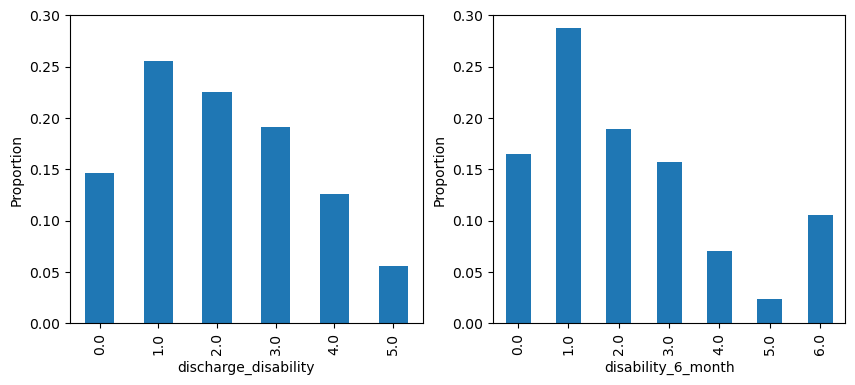

In [6]:
def describe_disability(timepoint, ax):
    '''
    For the specified timepoint, describe the proportion of people
    with each disability score and present in a plot
    timepoint: string e.g. discharge_disability
    ax: axes object to create plot on
    '''
    # Find and display proportion of people with each score
    mrs_6m = (data_full_alive_change[timepoint]
              .value_counts(normalize=True)
              .sort_index())

    # Create plot
    mrs_6m.plot(kind='bar', ax=ax)
    ax.set_xlabel(timepoint)
    ax.set_ylabel('Proportion')
    ax.set_ylim([0, 0.3])

    # Return results
    return mrs_6m


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
mrs_discharge = describe_disability('discharge_disability', ax[0])
mrs_6months = describe_disability('disability_6_month', ax[1])
display(pd.concat([mrs_discharge, mrs_6months], axis=1))
plt.show()

Observations:
* A greater proportion of patients at six months have lower mRS scores - e.g. 28.8% mRS 1 at six months, versus 25.5% at discharge
* Conversely, a lower proportion of patients at six months have higher mRS scores - e.g. 7.1% mRS 4 at six months, versus 12.6% at discharge - with the exception of mRS 6

As this focusses only on those with data at both time points, there are no individuals with an mRS score of 6 at discharge (as they would be dead and therefore can't be followed-up).

-5.0    0.000201
-4.0    0.003183
-3.0    0.024177
-2.0    0.092041
-1.0    0.218979
 0.0    0.315283
 1.0    0.196248
 2.0    0.086635
 3.0    0.035849
 4.0    0.013803
 5.0    0.009230
 6.0    0.004372
Name: discharge_to_6_month, dtype: float64

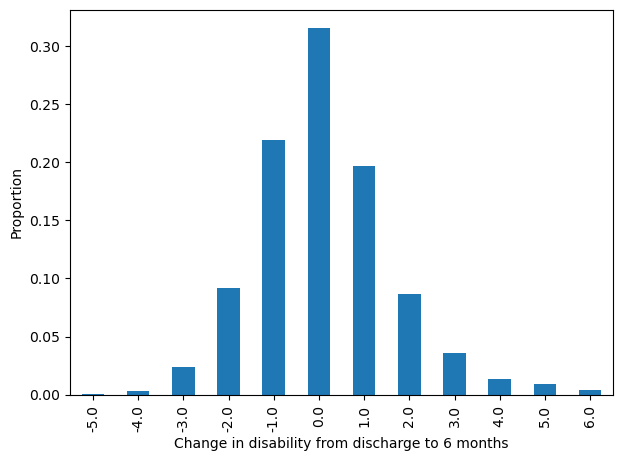

In [7]:
# Calculate change in disability
mrs_change = data_full_alive_change['discharge_to_6_month']

# Find proportion with each change
mrs_change_prop = mrs_change.value_counts(normalize=True).sort_index()
display(mrs_change_prop)

# Visualise distribution of changes
fig, ax = plt.subplots(figsize=(7, 5))
mrs_change_prop.plot(kind='bar', ax=ax)
ax.set_xlabel('Change in disability from discharge to 6 months')
ax.set_ylabel('Proportion')
plt.show()

Observations: 
* **Most frequently see no change** in disability (31.5%)
* **Looking at one or two mRS change, we see more people getting better**. One mRS better for 21.9% and one mRS worse for 19.6%. Two mRS better for 9.2% and two mRS worse for 8.7%
* **Looking at a change of 3 mRS or more, we see more people getting worse**. Three mRS better for 2.4% and three mRS worse for 3.6%. Very few of a change of four mRS or more. There are very few patients with four mRS (0.3%) or five mRS (0.02%) better. There are slightly more with worsening mRS - four mRS (0.1%), five mRS (0.09%) or six mRS (0.04%) worse

## Factors associated with disability at six months

In [8]:
def stacked_bar_6_month(variable, outcome, ax, order=False):
    '''
    Creates stacked bar of disability at 6 months, when patients are
    grouped by the specified variable
    Inputs:
    variable - string, e.g. 'prior_disability'
    outcome - string, disability outcome to plot
    ax - axis object to plot on
    order - array defining order for x axis (default False)
    '''
    df = (data_full_alive_change
          .groupby(variable)[outcome]
          .value_counts(normalize=True)
          .reset_index(name='prop')
          .pivot(columns=outcome,
                 index=variable,
                 values='prop'))
    if order:
        df.loc[order].plot(kind='bar', stacked=True, ax=ax)
    else:
        df.plot(kind='bar', stacked=True, ax=ax)
    ax.set_ylabel('Proportion')
    ax.get_legend().remove()

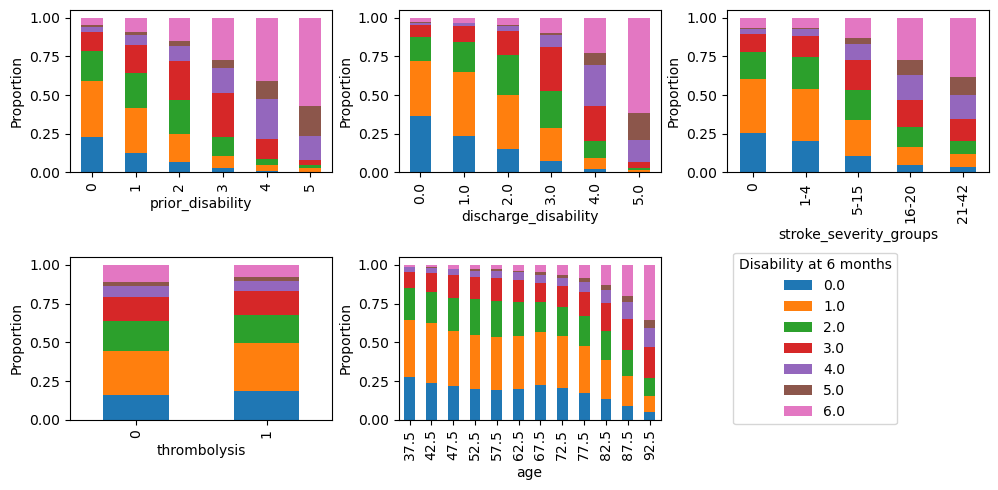

In [9]:
# Create stacked bar charts
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
stacked_bar_6_month('prior_disability', 'disability_6_month', ax[0, 0])
stacked_bar_6_month('discharge_disability', 'disability_6_month', ax[0, 1])
stacked_bar_6_month('stroke_severity_groups', 'disability_6_month', ax[0, 2],
                    order=nihss_choices)
stacked_bar_6_month('thrombolysis', 'disability_6_month', ax[1, 0])
stacked_bar_6_month('age', 'disability_6_month', ax[1, 1])

# Resize plots and add back in a legend
ax[1, 2].axis('off')
plt.tight_layout()
ax[1, 1].legend(loc='center left', bbox_to_anchor=(1.25, 0.5),
                title='Disability at 6 months')
plt.show()

**Observations:**

* **Prior disability and discharge disability** - on average, patients with greater prior or discharge disability have greater disability at six months, and vice versa. The majority of patients with a prior or discharge disability of 5 having died at six months.
* **Stroke severity** - patients with a higher stroke severity typically have a worse six month disability, and likewise a greater proportion have worse disability scores
* **Thrombolysis** - on average, a slightly higher proportion of thrombolysed patients have a six month disability score of 0 - but we see little difference when only grouping by whether thrombolysed or not
* **Age** - patients with older ages typically have a worse six month disability 

## Factors associated with change in disability

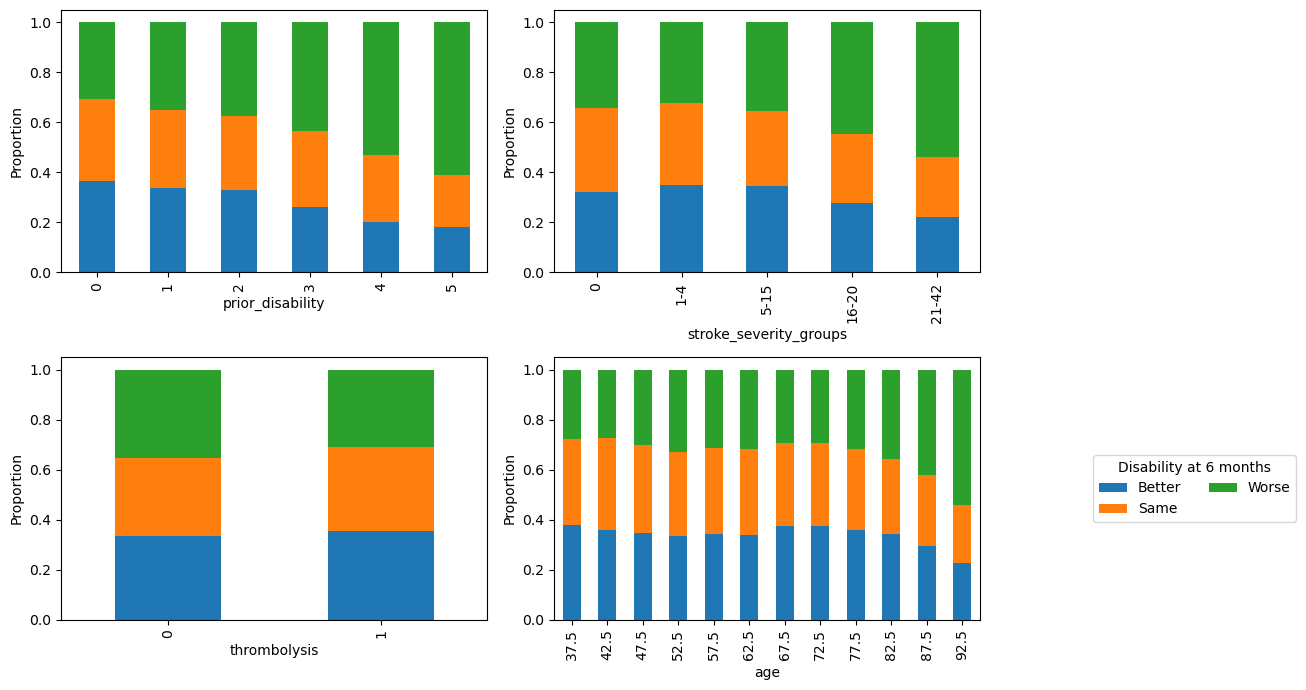

In [10]:
# Create box plots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
stacked_bar_6_month('prior_disability', 'compare', ax[0, 0])
stacked_bar_6_month('stroke_severity_groups', 'compare', ax[0, 1],
                    order=nihss_choices)
stacked_bar_6_month('thrombolysis', 'compare', ax[1, 0])
stacked_bar_6_month('age', 'compare', ax[1, 1])

# Remove empty axis, resize and show
plt.tight_layout()
ax[1, 1].legend(loc='center left', bbox_to_anchor=(1.25, 0.5),
                title='Disability at 6 months', ncol=2)
plt.show()

**Observations:** 
* Prior disability - with higher prior disability, a greater proportion of patients are worse at 6 months
* Stroke severity - with greater stroke severity, a higher proportion of patients are worse at 6 months
* Thrombolysis - there is a slighly higher proportion of patients who are worse at 6 months who did not receive thrombolysis
* Age - with older age, a greater proportion of patients are worse at six months